In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from envs import Space
from copy import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env_config = {'max_step': 1000, 'integrator': 'Leapfrog'}
env = Space(env_config)
env.reset()
log = []
t = []
done = False
while not done:
    act = np.array([0, 0])
    obs, R, done, _ = env.step(act)
    log.append(obs.copy())
    t.append(env.t)
    
log = np.array(log)
def plot(ax, x, y, lim=1):
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.scatter([0],[0])
    ax.plot(x, y, 'r+')
def plot3d(ax, x, y, z):
    ax.plot3D(x, y, z)
# fig = plt.figure(figsize=(18,8))
# plot(fig.add_subplot(121), log[:,4], log[:,5], 1.2)
# plot(fig.add_subplot(122), log[:,2]-log[:,4], log[:,3]-log[:,5], 1.2)
# plot3d(fig.add_subplot(121, projection='3d'), log[:,4], log[:,5], t)
# plot3d(fig.add_subplot(122, projection='3d'), log[:,2]-log[:,4], log[:,3]-log[:,5], t)
# plt.figure()
# plt.plot(t)

/root/hostCurUser/anaconda3/envs/ray/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/root/hostCurUser/anaconda3/envs/ray/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


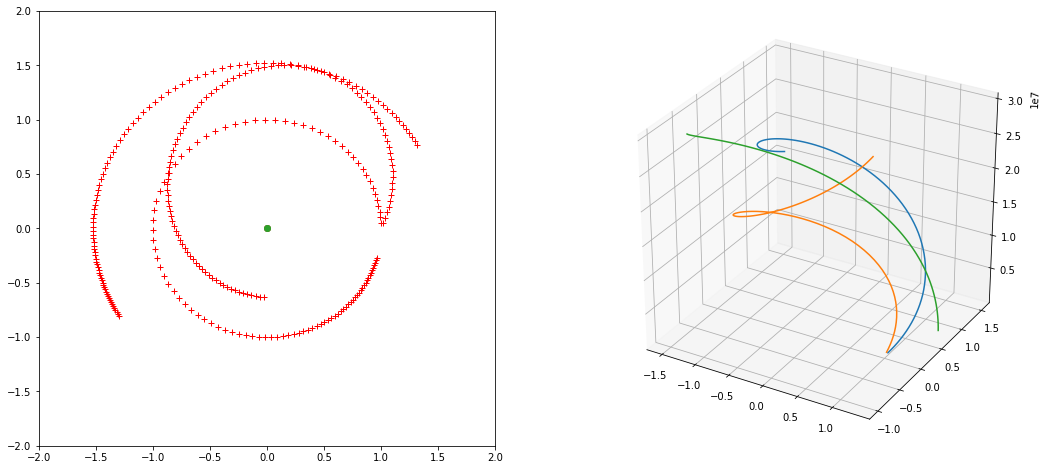

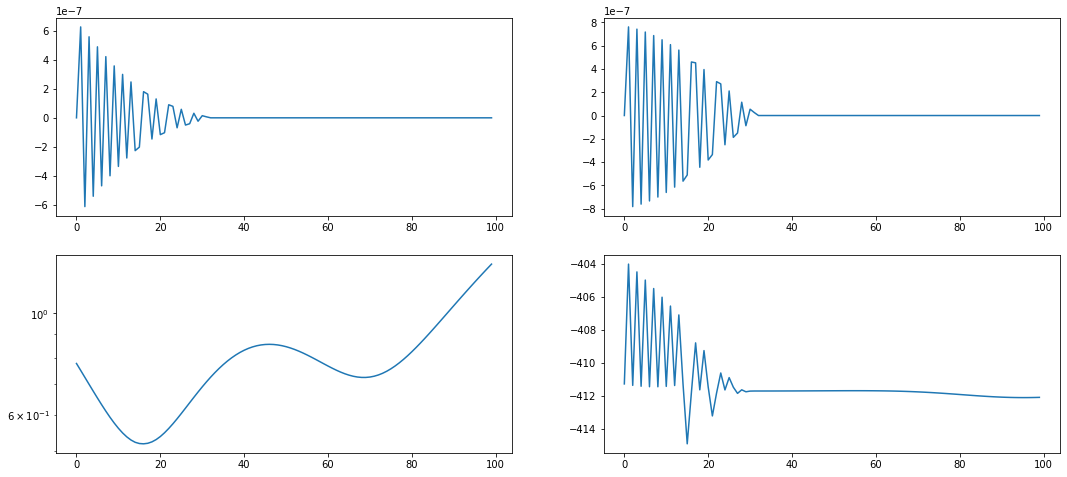

In [101]:
env_config = {'max_step': 100, 'integrator': 'Leapfrog'}
env = Space(env_config)
obs = env.reset()
step = 0
log = []
alog = []
t = []
done = False
def agent(env, obs):
    max_a = 1e-6
    v = torch.Tensor(obs[0:2])
    x = torch.Tensor(obs[2:4])
    x_e = torch.Tensor(obs[4:6])
    x_m = torch.Tensor(obs[6:8])
    v.requires_grad = True
    d = torch.norm
    
#     if d(x - x_e) < 1e-2: # escape the earth: 1.7e-3 the first Lagrangian point
#         act = (max_a * v / d(v)).data.numpy() # accelerator forward
#         return act
    
    # ref: https://en.wikipedia.org/wiki/Kepler_orbit
    alpha = env.G * env.M * env.au
    r = d(x)
    vr = (v[0] * x[0] + v[1] * x[1]) / r
    vt = (v[1] * x[0] - v[0] * x[1]) / r
    H = vt * r
    a = 1 / (2 / r - d(v)**2 / alpha) 
    p = d(H)**2 / alpha
    e = (1 - p / a)**0.5
    v0 = (alpha / p)**0.5
    theta = torch.atan2(x[1], x[0]) # current angle
    # Slow down for hyperbolic orbit
    if e > 1-1e-5 or a < 0:
        loss = e
        loss.backward()
        act = (max_a * -torch.tanh(v.grad / 1e-1))
#         act = torch.Tensor([0,0])
        return act.data.numpy()
    # Match the far point for ellipse orbit
    theta1 = torch.atan2(vr, vt - v0) # angle from near point
    theta2 = torch.sign(theta) * np.pi - theta1 # angle to far point
    # Time from near point
    # Integrate[(1/(1 + a Cos[x]))^2, x] =
    # (2 ArcTan[((1 - a) Tan[x/2])/Sqrt[-1 + a^2]])/(-1 + a^2)^(3/2) + 
    # (a Sin[x])/((-1 + a^2) (1 + a Cos[x]))
    # The integral is odd, negative if near point is not reached
    t_fromnear = (p * p / H * env.au) * (
        2*torch.atan((1-e)*torch.tan(theta1/2)/torch.sqrt(1-e*e))/(1-e*e)**1.5 +
        (-e*torch.sin(theta1))/((1-e*e)*(1+e*torch.cos(theta1))))
    # negative if far point is passed
    t_tofar = (p * p / H * env.au) * (
        2*torch.atan((1+e)*torch.tan(theta2/2)/torch.sqrt(1-e*e))/(1-e*e)**1.5 +
        (e*torch.sin(theta2))/((1-e*e)*(1-e*torch.cos(theta2))))
    t_orbit = 2 * np.pi * a * (a / alpha)**0.5 * env.au
    # time when the next far point is reached
    t_nextfar = env.t + t_tofar + t_orbit * (t_tofar < 0).float()
    
    r_far = a * (1 + e)
    theta_far = theta + theta2
    theta_far_m = t_nextfar * env.w_mars
    d_theta = (theta_far - theta_far_m + np.pi) % (2 * np.pi) - np.pi
    # It it's too far, do noting
    if torch.abs(d_theta) > np.pi / 2:
        act = torch.Tensor([0,0])
        return act.numpy()
    alog.append(d_theta)
    loss = torch.abs(r_far - env.r_mars) + 0 * torch.abs(d_theta) * (r_far + env.r_mars) / 2
    loss.backward()
    act = (max_a * -torch.tanh(v.grad / 1e-1))
    if torch.isnan(act[0]):
        f = lambda x: x/np.pi*180
        print(a, p, e,1-e*torch.cos(theta2))
        print(t_fromnear, a / alpha)
        raise
#     act = torch.Tensor([0,0])
    return act.numpy()
while not done:
    act = agent(env, obs)
    obs, R, done, _ = env.step(act)
    step += 1
#     if step % 10: print(act)
    log.append(np.hstack([obs.copy(), act.copy()]))
    t.append(env.t)
log = np.array(log)
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121)
plot(ax1, log[:,2], log[:,3], 2)
plot(ax1, log[:,4], log[:,5], 2)
plot(ax1, log[:,6], log[:,7], 2)
# plot(fig.add_subplot(122), log[:,2]-log[:,4], log[:,3]-log[:,5], 1e-3)
# fig = plt.figure(figsize=(18,18))
ax2 = fig.add_subplot(122, projection='3d')
plot3d(ax2, log[:,2], log[:,3], t)
plot3d(ax2, log[:,4], log[:,5], t)
plot3d(ax2, log[:,6], log[:,7], t)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,8))
d = np.linalg.norm
dist_to_mars = d(log[:,2:4]-log[:,6:8], axis=1)
v = d(log[:,0:2], axis=1)
r = d(log[:,2:4], axis=1)
alpha = env.G * env.M * env.au
E = v**2/2-alpha/r
H = log[:,1] * log[:,2] - log[:,0] * log[:,3]
# ax1.set_ylim([0,0.1])
ax1.plot(log[:,8])
ax2.plot(log[:,9])
ax3.set_yscale('log')
ax3.plot(dist_to_mars)
ax4.plot(E)